# Plot power spectra

plot output of scripts/2_compute_spectra.py  
  
created: Jan 23, 2023  
modified: April 5, 2023  
last modified: Feb 16, 2024

## Set-up

### Imports

In [2]:
# Imports - standard 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from specparam import SpectralModel

# Imports - custom
import sys
sys.path.append('../../scripts')
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS, N_ARRAYS
from plots import plot_psd_diff, plot_spectra_2conditions
from utils import comp_psd_diff

In [3]:
# Autoreload
%load_ext autoreload
%autoreload 2

### Set output paths

In [4]:
# create ouput dir
for path in [PROJECT_PATH, EXTERNAL_PATH]:
    dir_figs = f"{path}/figures/spectra"
    if not os.path.exists(dir_figs):
        os.makedirs(dir_figs)

#### examine spectra output for an example file

3
['tfr', 'time', 'freq']
TFR shape: (64, 128, 500)
Time shape: (500,)
Freq shape: (128,)
Pre-stimulus PSD shape: (64, 128)
Post-stimulus PSD shape: (64, 128)


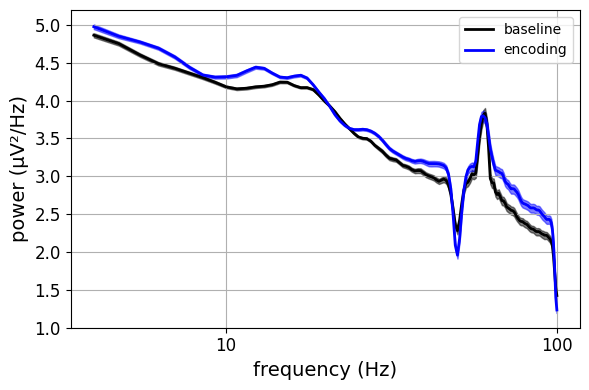

In [5]:
# load example psd and plot

# pick example file
i_sessions = 0
i_array = 6
nps_idx = (i_array+1) // 2
print(nps_idx)

# load and unpack
fname_in = f"{EXTERNAL_PATH}/data/lfp/lfp_tfr/{SESSIONS[i_sessions]}/NSP{nps_idx}_array{i_array}_LFP.npz"
data_in = np.load(fname_in)
tfr = data_in['tfr']
time = data_in['time']
freq = data_in['freq']

# split pre- and post-stimulus
psd_pre = np.mean(tfr[:,:,time<0], axis=-1)
psd_post = np.mean(tfr[:,:,time>0], axis=-1)

# plot spectra
plot_spectra_2conditions(psd_pre, psd_post, freq)

# print info
print(data_in.files)
print(f"TFR shape: {tfr.shape}")
print(f"Time shape: {time.shape}")
print(f"Freq shape: {freq.shape}")
print(f"Pre-stimulus PSD shape: {psd_pre.shape}")
print(f"Post-stimulus PSD shape: {psd_post.shape}")

In [9]:
# plot mean psd for each array

for i_session in range(len(SESSIONS)):
    print(f"Plotting: \t{SESSIONS[i_session]}")

    # create figure
    fig, axes = plt.subplots(7, 2, figsize=(10, 21), constrained_layout=True)
   
    # loop over arrays
    for ii, ax in enumerate(axes.flatten()):
        i_array = ii+1
        nps_idx = (i_array+1) // 2
        
        # load data
        fname_in = f"{EXTERNAL_PATH}/data/lfp/lfp_tfr/{SESSIONS[i_session]}/NSP{nps_idx}_array{i_array}_LFP.npz"
        data_in = np.load(fname_in)
        tfr = data_in['tfr']
        time = data_in['time']
        freq = data_in['freq']
        psd_pre = np.mean(tfr[:,:,time<0], axis=-1)
        psd_post = np.mean(tfr[:,:,time>0], axis=-1)
        
        # plot
        ax.set_title(f"Array {i_array}")
        plot_spectra_2conditions(psd_pre, psd_post, freq, ax=ax)

    # save
    fname_out = f"{dir_figs}/psd_arrays_{SESSIONS[i_session]}.png"
    plt.savefig(fname_out, transparent=False)
    plt.close()

Plotting: 	A_SNR_041018


c:\Users\micha\projects\v1_v4_1024_elec\.venv\lib\site-packages\specparam\plts\style.py:179: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


Plotting: 	A_SNR_140819
Plotting: 	L_SNR_250717


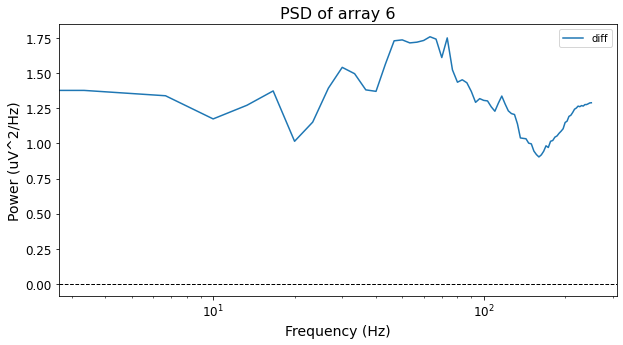

In [7]:
# compute differnce of log psd and plot

# compute log psd
log_psd_pre = np.log(psd_pre['spectra'])
log_psd_post = np.log(psd_post['spectra'])

# compute difference
log_psd_diff = log_psd_post - log_psd_pre

# plot log psd
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(psd_post['freq'], np.mean(log_psd_diff, axis=(0,1)), label='diff')

# label
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (uV^2/Hz)')
ax.set_title(f"PSD of array {i_array}")
ax.legend()

# annotate power=0
ax.axhline(0, color='k', linestyle='--', linewidth=1)

# scale x-axis logarithmically
ax.set(xscale="log");

In [8]:
# these have been developed into functions within the modules scripts.utils.py and scripts.plots.py

# def comp_psd_diff(psd_pre, psd_post):
#     """
#     Compute the difference of log psd.
    
#     Parameters
#     ----------
#     psd_pre : array
#         Array of pre-stimulus psd.
#     psd_post : array
#         Array of post-stimulus psd.

#     Returns
#     -------
#     log_psd_diff : array
#         Array of log psd difference.
    
#     """
    
#     # compute log psd
#     log_psd_pre = np.log(psd_pre)
#     log_psd_post = np.log(psd_post)
    
#     # compute difference
#     log_psd_diff = log_psd_post - log_psd_pre

#     return log_psd_diff

# def plot_psd_diff(freq, psd_diff):
#     """ Plot spectra (or spectral difference) in semi-log space."""
#     # plot psd
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     ax.plot(freq, psd_diff.T, color='grey')

#     # plot mean
#     ax.plot(freq, psd_diff.mean(axis=0), color='k', linewidth=3)

#     # label
#     ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Power (uV^2/Hz)')
#     ax.set_title(f"Power spectrum difference")

#     # annotate power=0
#     ax.axhline(0, color='r', linestyle='--', linewidth=3)

#     # scale x-axis logarithmically
#     ax.set(xscale="log");

#     return fig, ax

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Power spectrum difference'}, xlabel='Frequency (Hz)', ylabel='Power (uV^2/Hz)'>)

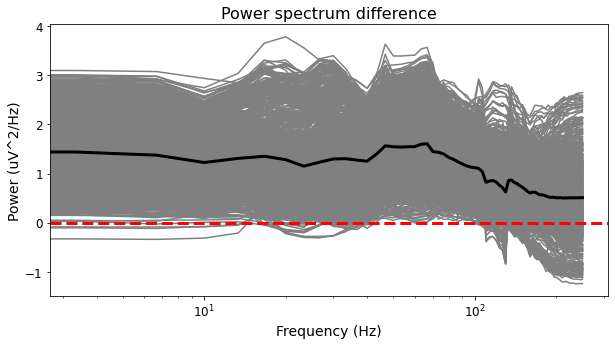

In [9]:
# aggregate PSDs across arrays, compute difference and plot

i_session = 0

# initialize
psd_pre_list = []
psd_post_list = []

# loop over sessions
for i_array in range(N_ARRAYS):
    # load psd
    nps_idx = (i_array+2) // 2
    fname_in = f"{PROJECT_PATH}/data/lfp/lfp_psd/{SESSIONS[i_session]}/NSP{nps_idx}_array{i_array+1}_LFP_XXX.npz"
    psd_pre_list.append(np.load(fname_in.replace('XXX', 'pre'))['spectra'])
    psd_post_list.append(np.load(fname_in.replace('XXX', 'post'))['spectra'])

# get freq vector
freq = np.load(fname_in.replace('XXX', 'pre'))['freq']

# join psds across arrays into single array
psd_pre = np.concatenate(psd_pre_list, axis=1)
psd_post = np.concatenate(psd_post_list, axis=1)

# compute log psd difference
psd_diff = comp_psd_diff(psd_pre, psd_post)

# average over trials
psd_diff_mean = np.mean(psd_diff, axis=0)

# plot
plot_psd_diff(freq, psd_diff_mean)


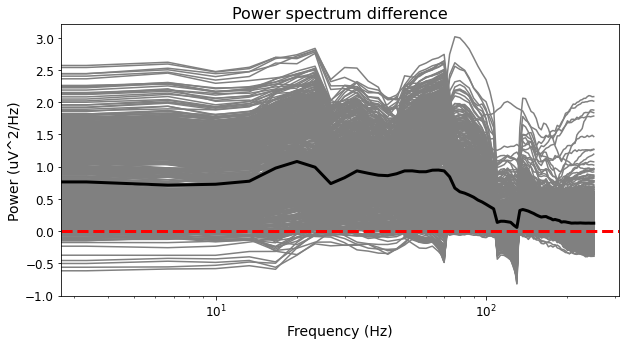

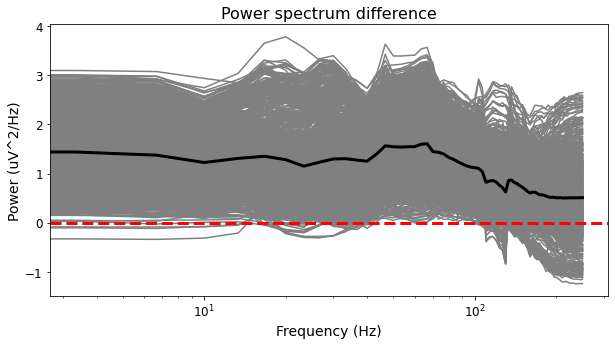

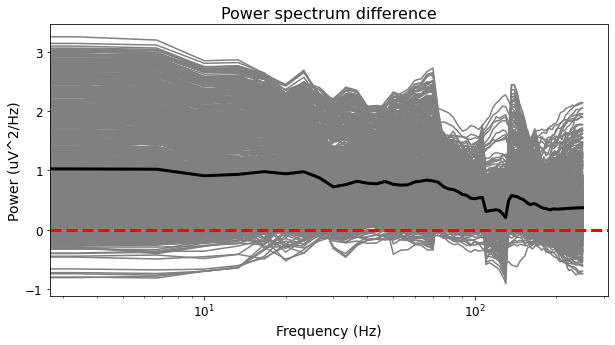

In [14]:
# repeat for all sessions and save fig to file

# loop over sessions
for i_session in range(len(SESSIONS)):
    print(f"Plotting: \t{SESSIONS[i_session]}")

    # initialize
    psd_pre_list = []
    psd_post_list = []

    # loop over sessions
    for i_array in range(N_ARRAYS):
        # load psd
        nps_idx = (i_array+2) // 2
        fname_in = f"{PROJECT_PATH}/data/lfp/lfp_psd/{SESSIONS[i_session]}/NSP{nps_idx}_array{i_array+1}_LFP_XXX.npz"
        psd_pre_list.append(np.load(fname_in.replace('XXX', 'pre'))['spectra'])
        psd_post_list.append(np.load(fname_in.replace('XXX', 'post'))['spectra'])

    # get freq vector
    freq = np.load(fname_in.replace('XXX', 'pre'))['freq']

    # join psds across arrays into single array
    psd_pre = np.concatenate(psd_pre_list, axis=1)
    psd_post = np.concatenate(psd_post_list, axis=1)

    # compute log psd difference
    psd_diff = comp_psd_diff(psd_pre, psd_post)

    # average over trials
    psd_diff_mean = np.mean(psd_diff, axis=0)

    # plot
    fname_out = f"{dir_figs}/psd_diff_{SESSIONS[i_session]}.png"
    plot_psd_diff(freq, psd_diff_mean, fname_out=fname_out)
